In [1]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import gc
import collections
import statsmodels.api as sm
import scipy
import xarray as xr

# Third-party dependencies
# NOTE: Local xeofs to be submitted as pull-request (addition of xeofs.model.reconstruct_randomized_X method)
from xeofs.xarray import EOF
from xarrayutils.utils import linear_trend

In [2]:
# Define local plotting parameters
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 25})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')

In [3]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
cise_file_path = 'cise_data/'
reconstructions_neofs_path = 'reconstructions_neofs/'
std_file_path = 'standardized_rec_data/'

## Data input (pre-processed)

In [4]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();
# Specify projection for data file
data.rio.write_crs("epsg:3031",inplace=True);
# Specify projection for data file flux array
flux.rio.write_crs("epsg:3031",inplace=True);

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## Processed/Clean Data Input

In [5]:
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

In [6]:
flux_clean_tmean = flux_clean.mean('time')
flux_clean_tstd = flux_clean.std('time')

## Data Standardization

In [8]:
flux_clean_demeaned = flux_clean - flux_clean_tmean
flux_clean_standardized = flux_clean_demeaned/flux_clean_tstd

In [9]:
flux_clean_ts = flux_clean.sum(['x','y'])
flux_clean_demeaned_ts = flux_clean_demeaned.sum(['x','y'])
flux_clean_standardized_ts = flux_clean_standardized.mean(['x','y'])

Text(0.5, 0, 'Time (months)')

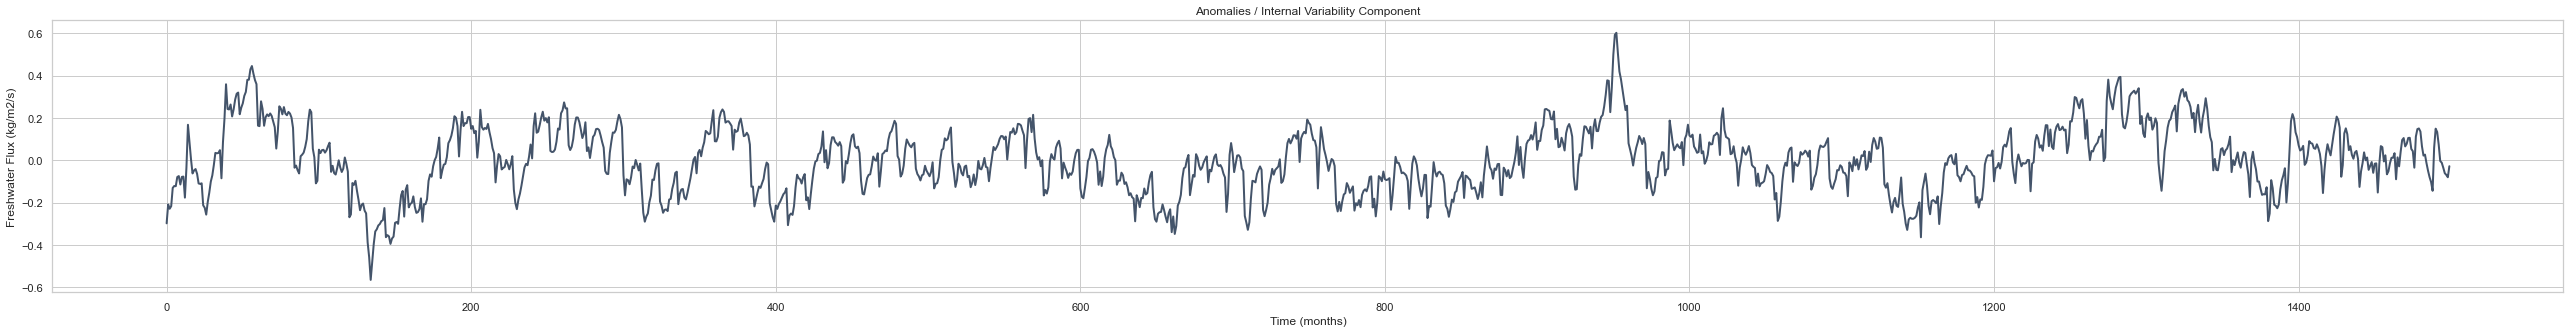

In [10]:
# Figure: Anomalies / Internal Variability Component of Input Data: Temporal Variability
plt.figure(figsize=(45,5))
plt.plot(flux_clean_standardized_ts[:], color = '#44546A', linewidth=2)
#plt.plot(flux_clean_ts[:], color = 'r', linewidth=2)
#plt.plot(flux_clean_demeaned_ts[:], color = 'r', linewidth=2)
plt.title('Anomalies / Internal Variability Component')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

## Spatial Decomposition: EOF

In [11]:
%%time
model = EOF(flux_clean_standardized)
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()

CPU times: user 54.2 s, sys: 21.7 s, total: 1min 15s
Wall time: 19.7 s


## Figures

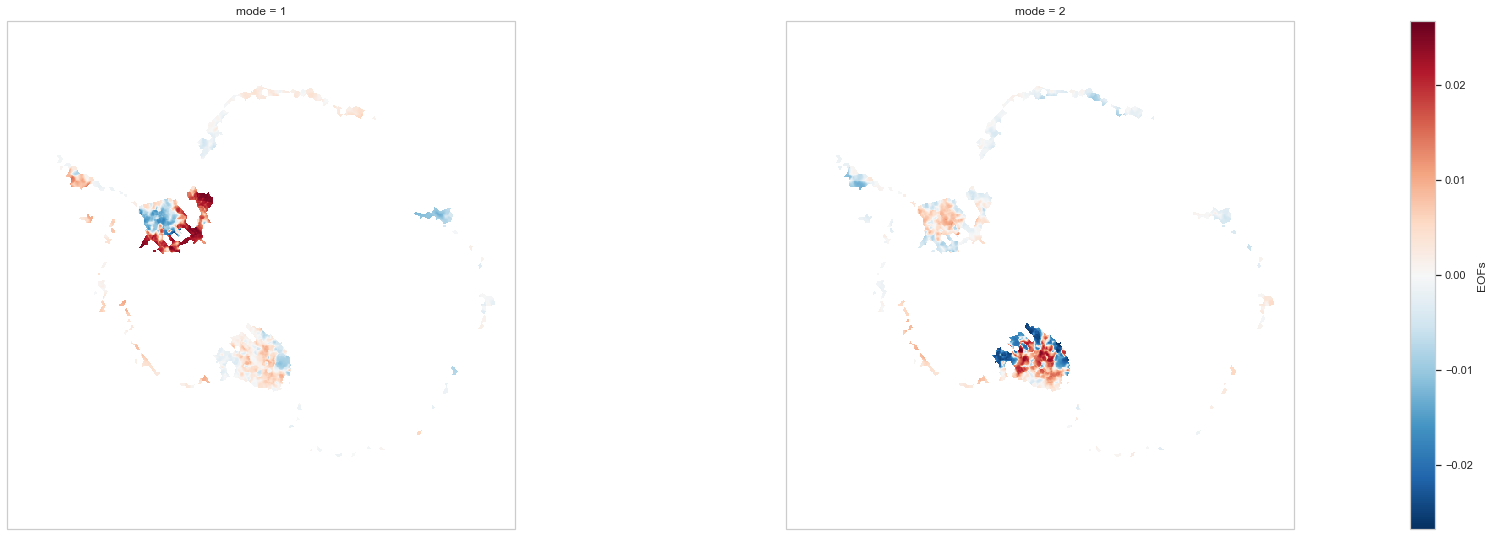

In [12]:
# Figure: Dominant EOF modes
fg = eofs[:,:,0:2].plot(aspect=2,
                        size=8,
                        col="mode", 
                        col_wrap=2,
                        subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

# TODO: Redefine vmax, vmin 

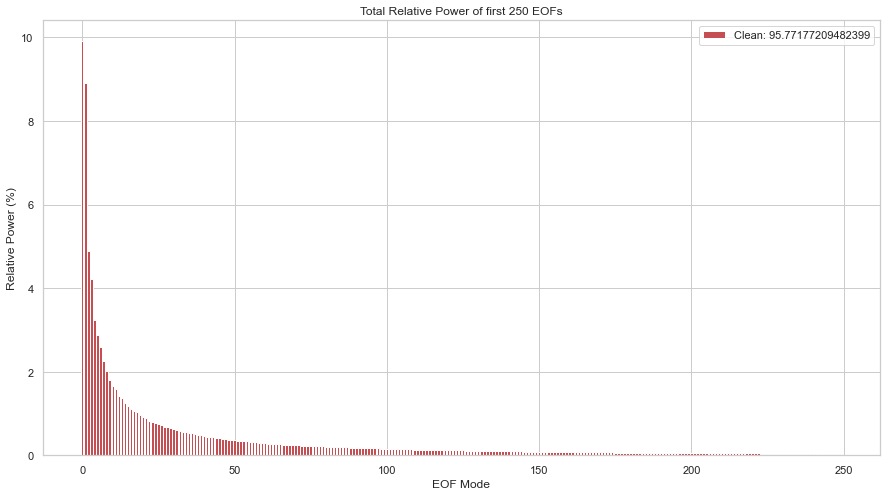

In [13]:
# Figure: Relative power of m EOFs
m = 250

plt.figure(figsize=(15,8))
plt.bar(range(m),varexpl[:m]*100, 
        color='r', 
        label='Clean: {}'.format(varexpl[:m].sum().values*100))
plt.ylabel('Relative Power (%)')
plt.xlabel('EOF Mode')
plt.title('Total Relative Power of first {} EOFs'.format(m))
plt.legend()

## Fourier Phase Randomization

In [14]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 1
t_length = pcs.shape[0]

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,pcs.shape[0],pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization {}, mode: {}'.format(i,m))

calculated ifft for realization 0, mode: 0
calculated ifft for realization 0, mode: 1
calculated ifft for realization 0, mode: 2
calculated ifft for realization 0, mode: 3
calculated ifft for realization 0, mode: 4
calculated ifft for realization 0, mode: 5
calculated ifft for realization 0, mode: 6
calculated ifft for realization 0, mode: 7
calculated ifft for realization 0, mode: 8
calculated ifft for realization 0, mode: 9
calculated ifft for realization 0, mode: 10
calculated ifft for realization 0, mode: 11
calculated ifft for realization 0, mode: 12
calculated ifft for realization 0, mode: 13
calculated ifft for realization 0, mode: 14
calculated ifft for realization 0, mode: 15
calculated ifft for realization 0, mode: 16
calculated ifft for realization 0, mode: 17
calculated ifft for realization 0, mode: 18
calculated ifft for realization 0, mode: 19
calculated ifft for realization 0, mode: 20
calculated ifft for realization 0, mode: 21
calculated ifft for realization 0, mode: 2

calculated ifft for realization 0, mode: 544
calculated ifft for realization 0, mode: 545
calculated ifft for realization 0, mode: 546
calculated ifft for realization 0, mode: 547
calculated ifft for realization 0, mode: 548
calculated ifft for realization 0, mode: 549
calculated ifft for realization 0, mode: 550
calculated ifft for realization 0, mode: 551
calculated ifft for realization 0, mode: 552
calculated ifft for realization 0, mode: 553
calculated ifft for realization 0, mode: 554
calculated ifft for realization 0, mode: 555
calculated ifft for realization 0, mode: 556
calculated ifft for realization 0, mode: 557
calculated ifft for realization 0, mode: 558
calculated ifft for realization 0, mode: 559
calculated ifft for realization 0, mode: 560
calculated ifft for realization 0, mode: 561
calculated ifft for realization 0, mode: 562
calculated ifft for realization 0, mode: 563
calculated ifft for realization 0, mode: 564
calculated ifft for realization 0, mode: 565
calculated

calculated ifft for realization 0, mode: 1134
calculated ifft for realization 0, mode: 1135
calculated ifft for realization 0, mode: 1136
calculated ifft for realization 0, mode: 1137
calculated ifft for realization 0, mode: 1138
calculated ifft for realization 0, mode: 1139
calculated ifft for realization 0, mode: 1140
calculated ifft for realization 0, mode: 1141
calculated ifft for realization 0, mode: 1142
calculated ifft for realization 0, mode: 1143
calculated ifft for realization 0, mode: 1144
calculated ifft for realization 0, mode: 1145
calculated ifft for realization 0, mode: 1146
calculated ifft for realization 0, mode: 1147
calculated ifft for realization 0, mode: 1148
calculated ifft for realization 0, mode: 1149
calculated ifft for realization 0, mode: 1150
calculated ifft for realization 0, mode: 1151
calculated ifft for realization 0, mode: 1152
calculated ifft for realization 0, mode: 1153
calculated ifft for realization 0, mode: 1154
calculated ifft for realization 0,

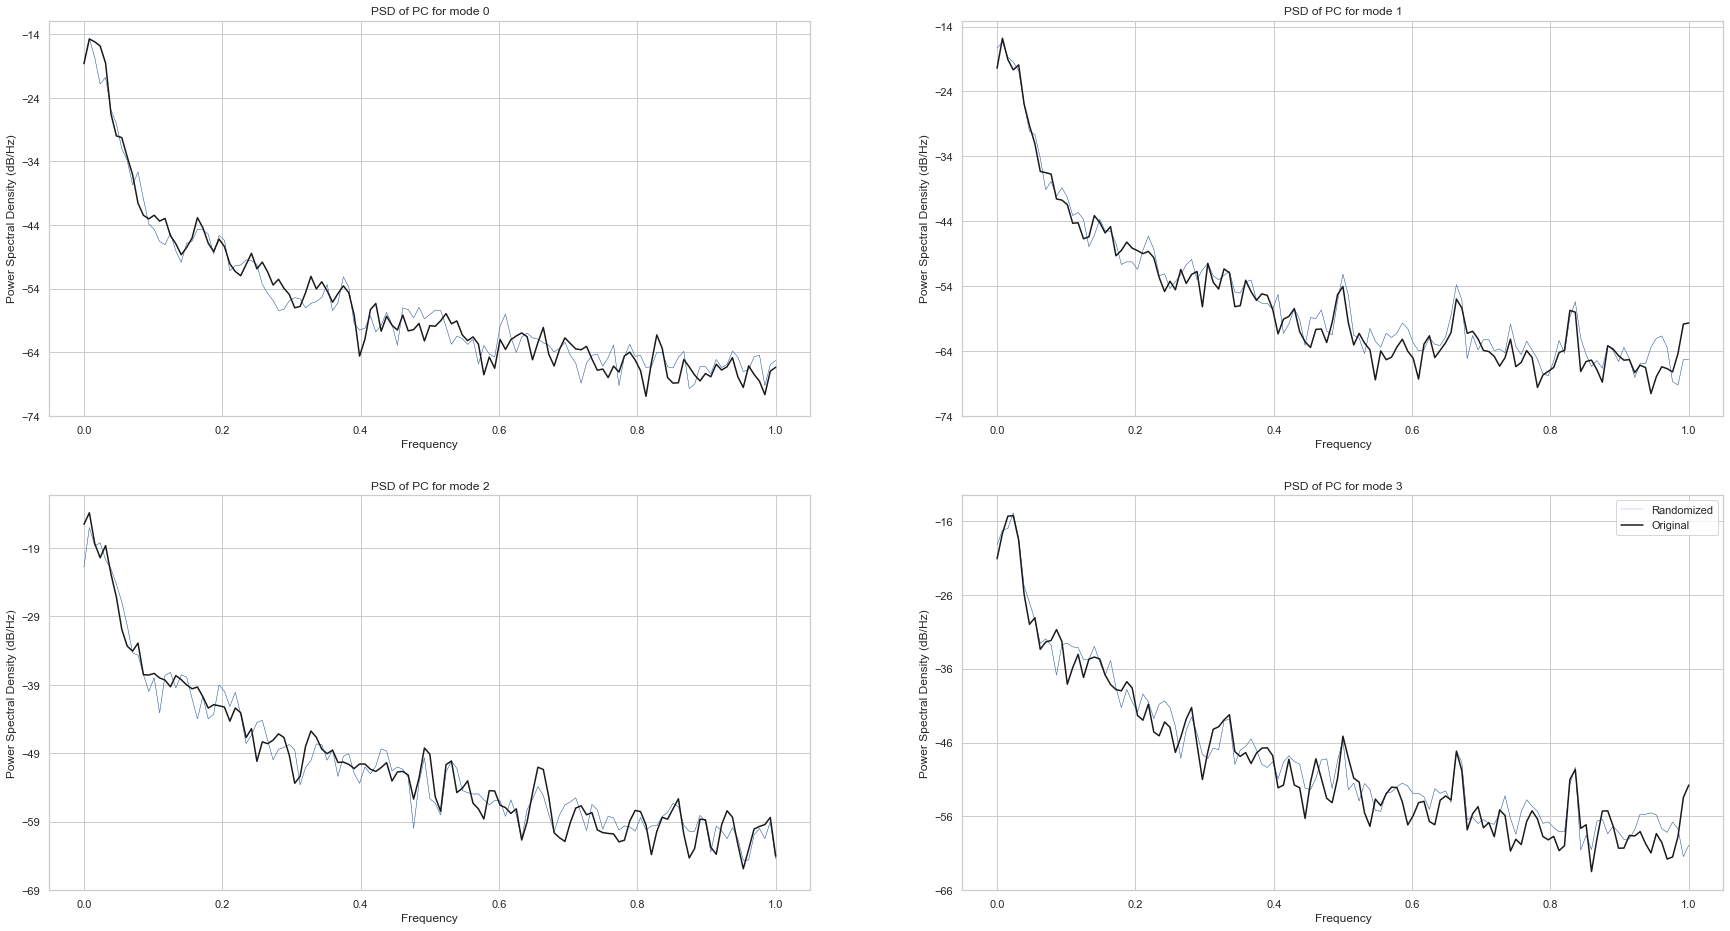

In [15]:
# FIGURE (FOR TESTING)

fig, axs = plt.subplots(2,2,figsize=(30,16))
axs=axs.ravel()

for mode_m in range(0,4):
    for i in range(0,1):
        axs[mode_m].psd(new_fl[i,:,mode_m],color='b', linewidth=0.5)
    axs[mode_m].psd(new_fl[0,:,mode_m],color='b', linewidth=0.25,label='Randomized')
    axs[mode_m].psd(pcs[:,mode_m],color='k', linewidth=1.5,label='Original')
    axs[mode_m].set_title('PSD of PC for mode {}'.format(mode_m))
plt.legend()

## Helper Functions

In [16]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

In [17]:
def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

In [18]:
# Reconstruct flux dataset using phase randomized PCs
# This section is to be called iteratively for ensemble runs with multiple realizations
# This method also takes 'modes' as a parameter: 
# which is used to reconstruct dataset with different number of selected modes

def generate_data(n_realization,mode,mode_skip):
    flux_reconstr = model.reconstruct_randomized_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

In [19]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data

## Generator

In [20]:
# Generate dataset realizations
# Note standardized input data to the initial PCA 
for i in range(n_realizations):
    flux_reconstr = generate_data(i, 1500, 1)
    flux_reconstr = (flux_reconstr*flux_clean_tstd)+flux_clean_tmean
    flux_reconstr.to_netcdf(inDirName+interim_data_folder+
                            cise_file_path+std_file_path+"flux_reconstr_std_{}.nc".format(i))
    del flux_reconstr
    gc.collect()
    print('reconstructed realization # {}'.format(i))

reconstructed realization # 0


In [21]:
# change file name for other realizations
flux_reconstr0 = xr.open_dataset(inDirName+interim_data_folder+
                                 cise_file_path+std_file_path+'flux_reconstr_std_0.nc')
flux_reconstr0 = flux_reconstr0.__xarray_dataarray_variable__

In [22]:
basins = np.array((34,55,114,103,104,105))

In [23]:
for basin in basins:
    orig = clip_data(flux_clean, basin)
    rec0 = clip_data(flux_reconstr0, basin)
    orig.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_{}".format(basin))
    rec0.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_{}".format(basin))
    del orig, rec0
    gc.collect()

In [24]:
# Amery 34
orig_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_34")
rec0_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_34")

# Filchner 55
orig_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_55")
rec0_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_55")

# Thwaites 114
orig_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_114")
rec0_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_114")

# Ronne 103
orig_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_103")
rec0_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_103")

# Western Ross 104
orig_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_104")
rec0_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_104")

# Eastern Ross 105
orig_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_105")
rec0_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_105")

In [25]:
# Amery 
orig_34_ts = time_series(orig_34)
rec0_34_ts = time_series(rec0_34)

# Filchner 
orig_55_ts = time_series(orig_55)
rec0_55_ts = time_series(rec0_55)

# Thwaites 
orig_114_ts = time_series(orig_114)
rec0_114_ts = time_series(rec0_114)

# Ronne 
orig_103_ts = time_series(orig_103)
rec0_103_ts = time_series(rec0_103)

# Western Ross 
orig_104_ts = time_series(orig_104)
rec0_104_ts = time_series(rec0_104)

# Eastern Ross 
orig_105_ts = time_series(orig_105)
rec0_105_ts = time_series(rec0_105)

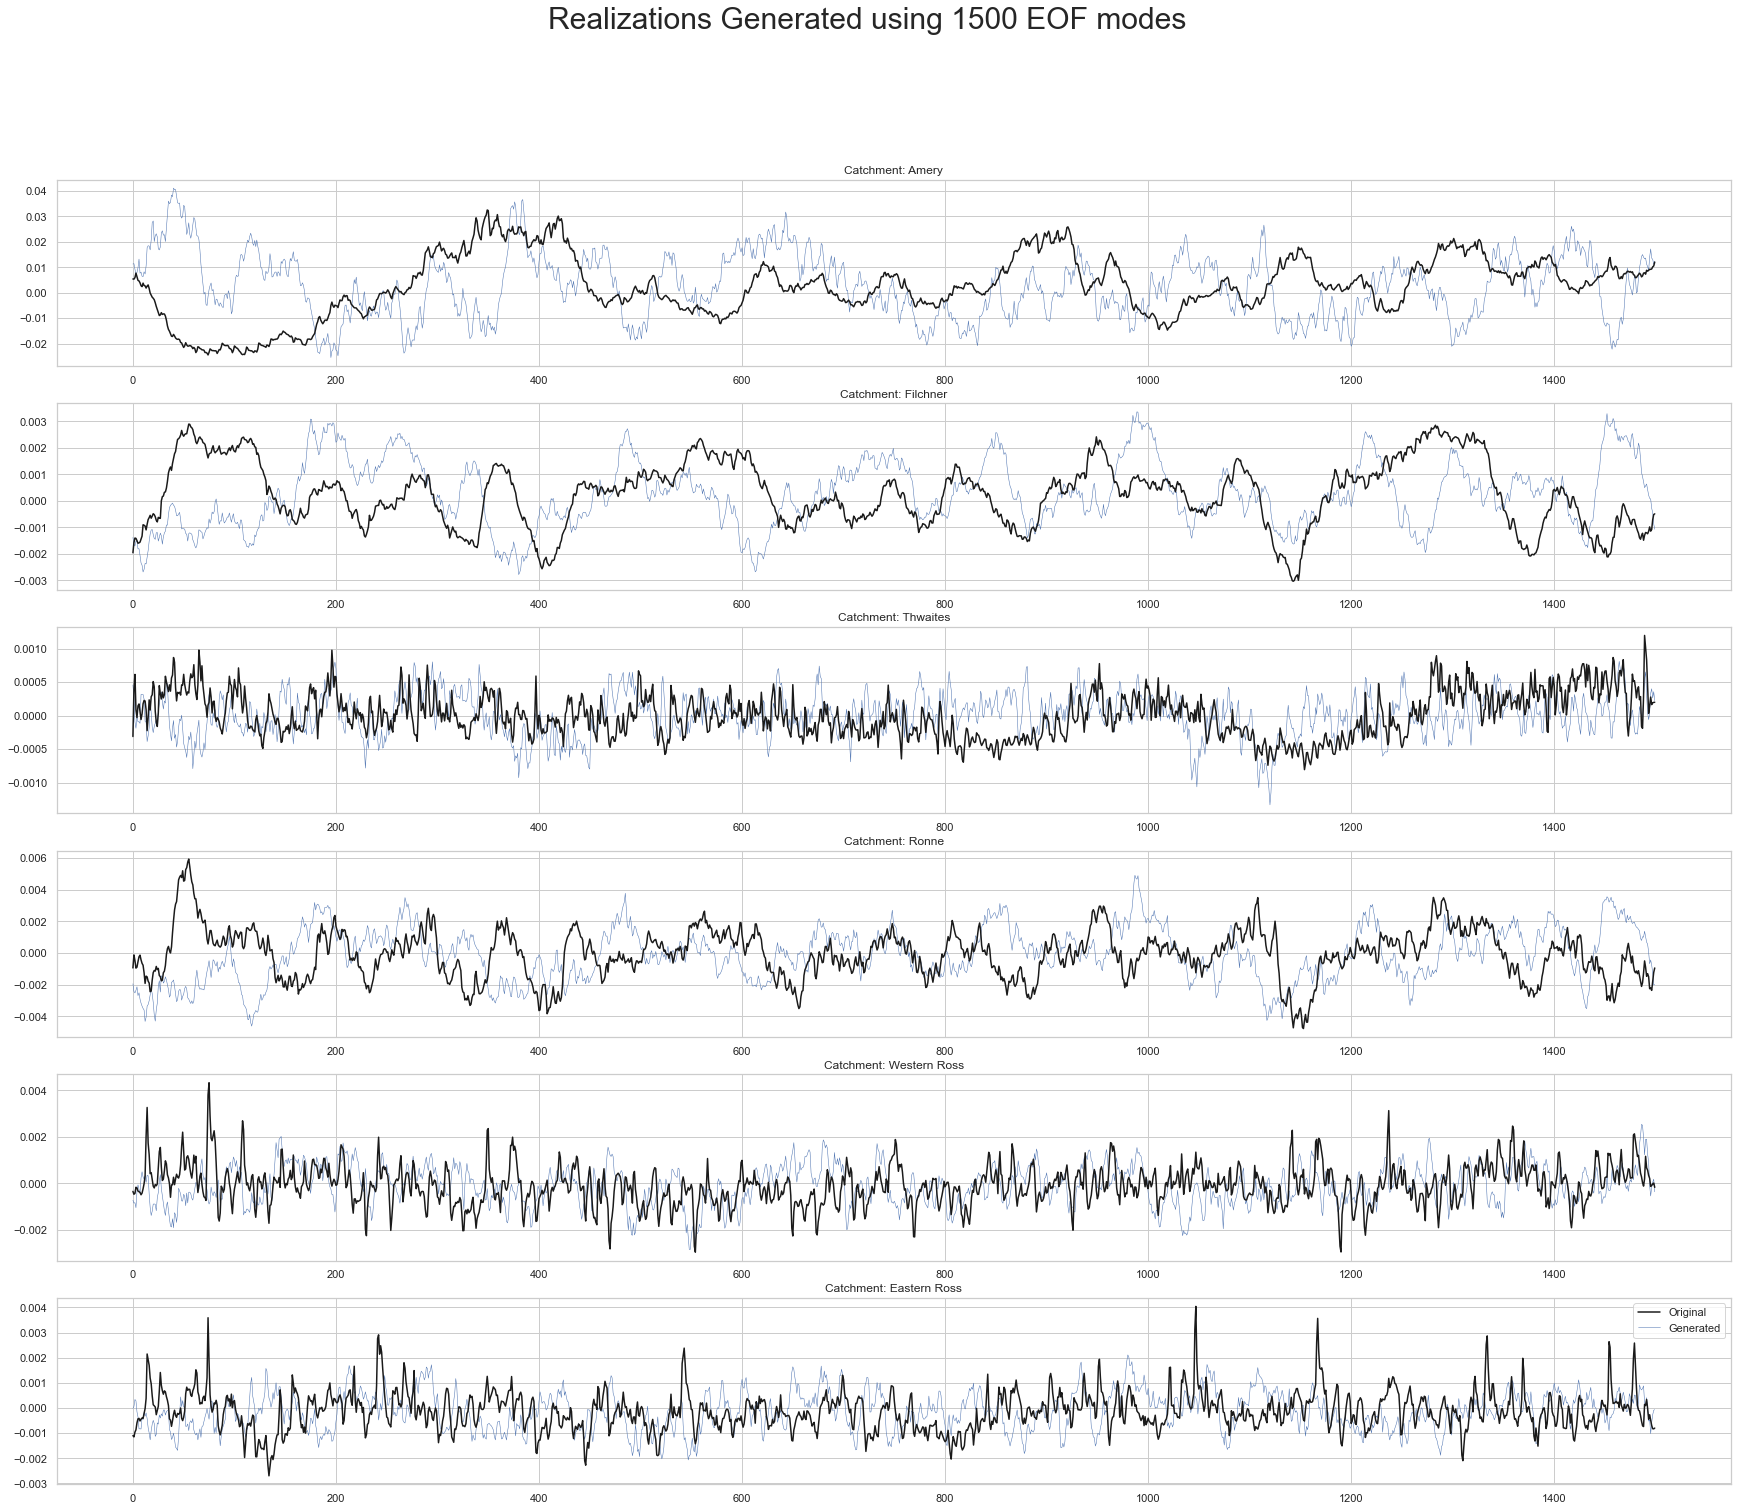

In [26]:
fig, axs = plt.subplots(6,1,figsize=(30,24))
axs=axs.ravel()

axs[0].plot(orig_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[0].plot(rec0_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[0].set_title('Catchment: Amery');

axs[1].plot(orig_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[1].plot(rec0_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[1].set_title('Catchment: Filchner');

axs[2].plot(orig_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[2].plot(rec0_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[2].set_title('Catchment: Thwaites');

axs[3].plot(orig_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[3].plot(rec0_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[3].set_title('Catchment: Ronne');

axs[4].plot(orig_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[4].plot(rec0_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[4].set_title('Catchment: Western Ross');

axs[5].plot(orig_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[5].plot(rec0_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()

plt.suptitle('Realizations Generated using 1500 EOF modes');

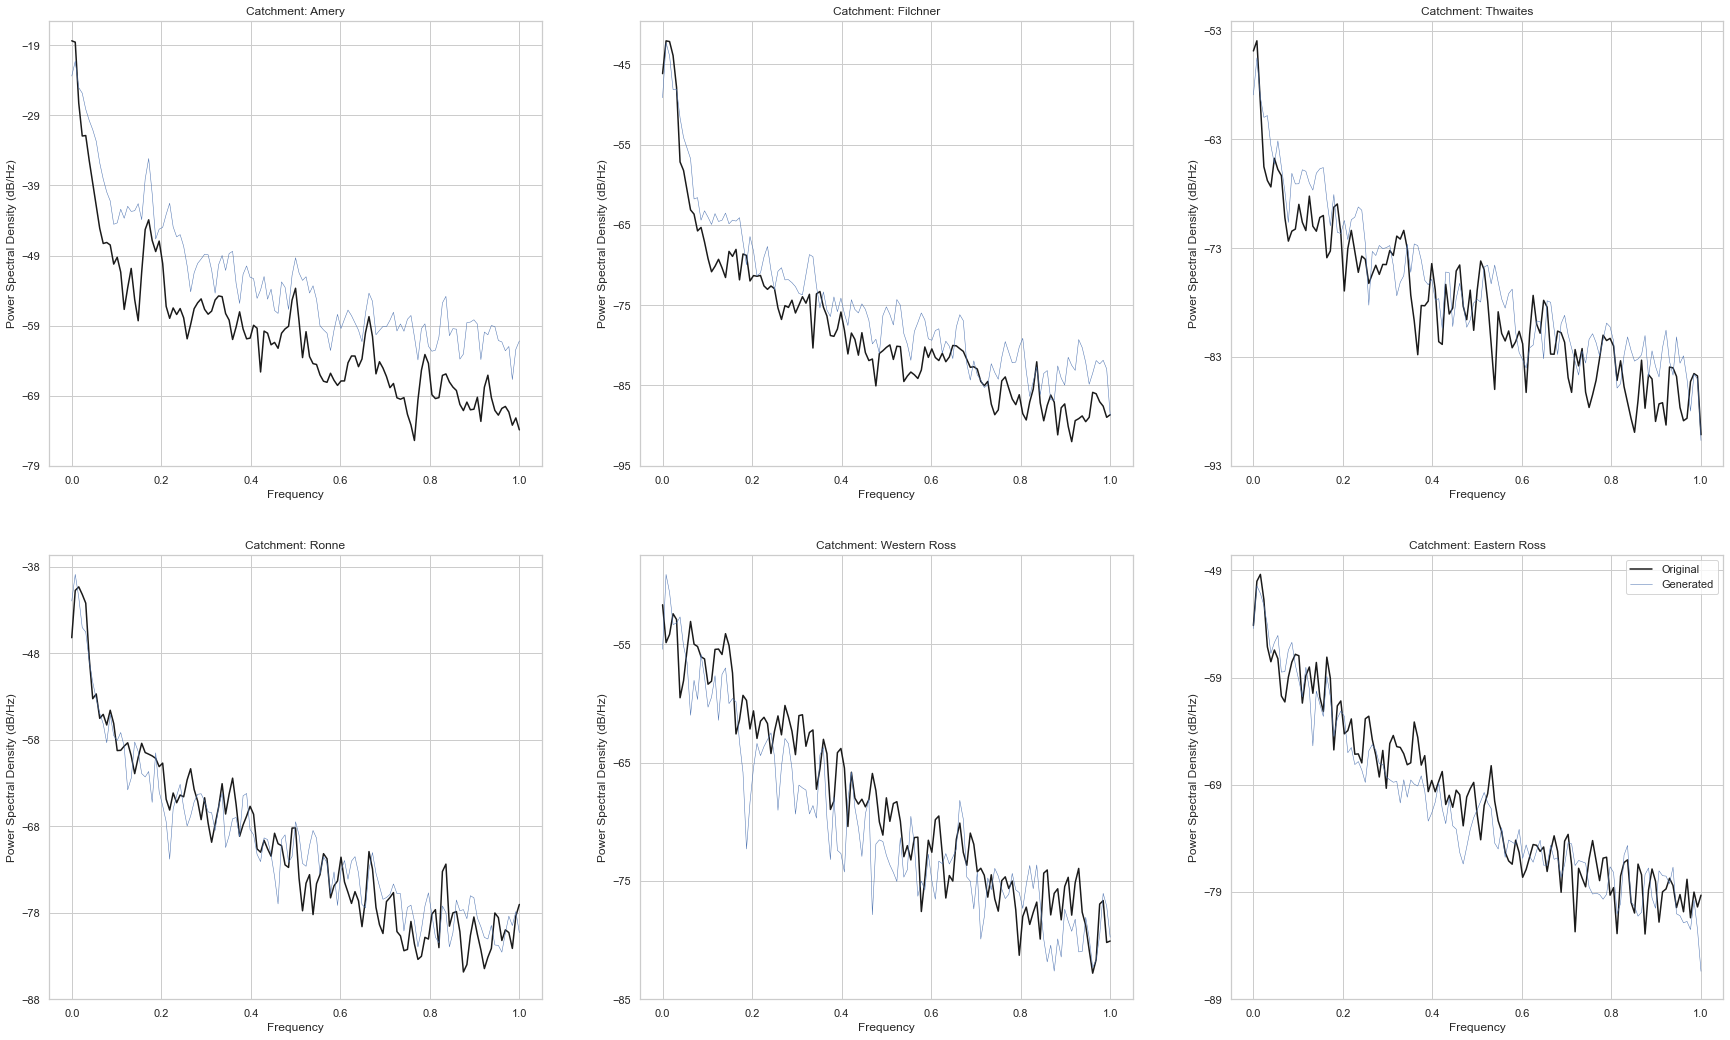

In [27]:
fig, axs = plt.subplots(2,3,figsize=(30,18))
axs=axs.ravel()

axs[0].psd(orig_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[0].psd(rec0_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[0].set_title('Catchment: Amery');

axs[1].psd(orig_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[1].psd(rec0_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[1].set_title('Catchment: Filchner');

axs[2].psd(orig_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[2].psd(rec0_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[2].set_title('Catchment: Thwaites');

axs[3].psd(orig_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[3].psd(rec0_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[3].set_title('Catchment: Ronne');

axs[4].psd(orig_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[4].psd(rec0_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[4].set_title('Catchment: Western Ross');

axs[5].psd(orig_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[5].psd(rec0_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()